# Plots for BSC

In [11]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [12]:
# Setup notebook
nbconfig = Nb.setup_notebook(ref_dir='../references/lcdb-references')

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2019-02-20 
Git hash: 2db29778708209bb252d7237edb7fb6db71d3f3a


In [13]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [14]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sramongo']
ncbi = db['ncbi']

In [52]:
sns.set_context('poster')
plt.rcParams.update(
    {
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold'
    }
)

# There is a lot of data.

In [16]:
df = (
    pd.DataFrame(list(
        ncbi.aggregate([
            {'$unwind': {'path': '$runs'}},
            {
                '$project': {
                    '_id': False,
                    'srx': '$srx',
                    'srr': '$runs.srr',
                    'date': '$runs.load_date',
                    'size_MB': '$runs.size_MB'
                }
            },
        ])
    ))
    .set_index(['srx', 'srr'])
    .assign(date=lambda df: pd.to_datetime(df.date))
    .sort_values('date')
    .assign(cum_sum_TB = lambda df: df.size_MB.cumsum() / 1e6)
    .assign(year=lambda df: df.date.dt.year)
    .dropna()
    .assign(year=lambda df: df.year.astype(int))
)

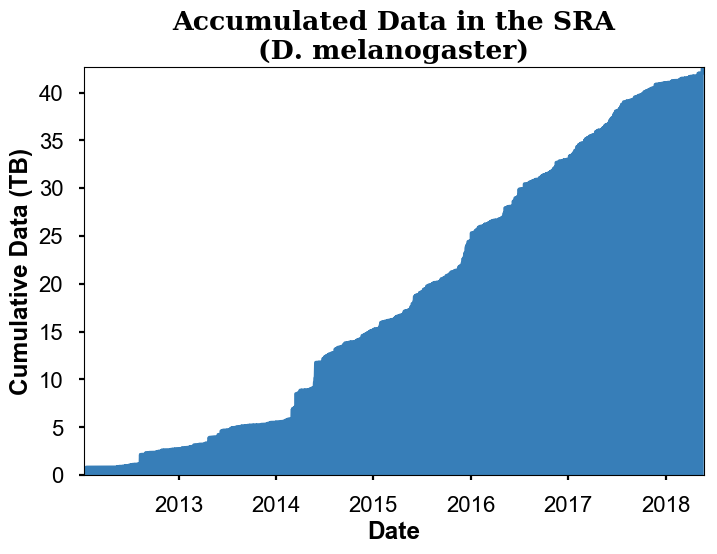

In [72]:
fig, ax = plt.subplots()
df.plot('date', 'cum_sum_TB', ax=ax, legend=False)
ax.fill_between(df.date.dt.to_pydatetime(), 0, df['cum_sum_TB'])

fig.autofmt_xdate(rotation=0, ha='center')
ax.margins(0)
ax.set(xlabel = 'Date', ylabel = 'Cumulative Data (TB)')
ax.set_title('Accumulated Data in the SRA\n(D. melanogaster)', family='serif')

fig.savefig('/home/fearjm/Documents/data_in_sra.svg', bbox_inches='tight')

# I can use the data to figure out library strategy

In [73]:
strategy = (
    pd.read_parquet('../output/metadata-wf/select_library_strategy.parquet')
    .rename(columns={'Fear_et_al_library_strategy': 'library_strategy'})
    .library_strategy
    .pipe(lambda x: x[~x.str.contains('\|')])
    #.pipe(lambda x: x[x.isin(['RNA-Seq', 'WGS'])])
)

In [ ]:
feature_names = (
    pd.read_csv('../output/metadata-wf/random_forest_library_strategy_feature_importance.tsv', sep='\t', header=None, names=['feature', 'importance'])
    .sort_values('importance', ascending=False)
    .head(20)
    .feature
    .values
    .tolist()
)

In [ ]:
df = (
    pd.read_parquet('../output/metadata-wf/build_library_strategy_feature_set.parquet', columns=feature_names)
    .join(strategy, how='inner')
)

In [ ]:
g = sns.PairGrid(df.head(100), hue='library_strategy')